<font color='tomato'><font color="#CC3D3D"><p>
# DNN Modeling for Multiclass Classification

**전역변수 설정**

In [1]:
DNN_VERSION = 2.0  # submission 화일명에 사용
SEED = 0          # random_state 지정
BATCH_SIZE = 42    # batch size 지정

##### Import modules

!pip install tensorflow

!pip install -q -U keras-tuner

In [1]:
import pandas as pd
import numpy as np
import os
import random
from IPython.display import Image, clear_output
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
print(tf.__version__)

2.9.3


##### Set random seeds to make your results reproducible

In [3]:
# 매번 모델링을 할 때마다 동일한 결과를 얻으려면 아래 코드를 실행해야 함.

def reset_seeds(seed, reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")  # optional

    np.random.seed(seed)
    random.seed(seed)
    tf.compat.v1.set_random_seed(seed)
#    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
reset_seeds(0)

### Step 1: Load and process the data

##### Read data

In [4]:
X_train = pd.read_csv('/kaggle/input/ml-final-exam-type-01/X_train_exam_01.csv', encoding='cp949').drop('custid', axis=1)
y_train = pd.read_csv('/kaggle/input/ml-final-exam-type-01/y_train_exam_01.csv').group
X_test = pd.read_csv('/kaggle/input/ml-final-exam-type-01/X_test_exam_01.csv', encoding='cp949')
IDtest = X_test.ID.unique()
X_test = X_test.drop('ID', axis=1)

X_train.head()

,f000,f001,f002,f003,f004,f005,f006,f007,f008,f009,...,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127
0,0.154932,0.105392,0.068760,0.213738,0.178632,0.185432,0.115931,0.220182,0.049942,0.053519,...,0.129909,0.019110,0.155175,0.118905,0.128475,0.194789,0.250839,0.114440,0.188980,0.124858
1,0.150265,0.113493,0.053723,0.279898,0.220548,0.216846,0.142696,0.249474,0.080952,0.048257,...,0.147738,0.064068,0.207723,0.158806,0.149532,0.215697,0.397651,0.184792,0.182523,0.161461
2,0.163253,0.206024,0.179661,0.253725,0.175406,0.261342,0.212712,0.190733,0.200579,0.076563,...,0.178145,0.087018,0.246528,0.208857,0.079992,0.257902,0.419524,0.318593,0.067054,0.224041
3,0.119036,0.094877,0.061333,0.186340,0.070998,0.166113,0.163255,0.219687,0.068889,0.096517,...,0.057782,0.054187,0.218044,0.099540,0.154490,0.144451,0.194623,0.195095,0.159906,0.086877
4,0.216432,0.172594,0.221798,0.295499,0.245131,0.402211,0.161807,0.313463,0.118416,0.073019,...,0.261979,0.078613,0.318539,0.224083,0.143784,0.372206,0.367924,0.301673,0.187598,0.246487


In [5]:
num_categories = y_train.nunique()

In [6]:
categories = y_train.astype('category').cat.categories

##### One-hot-encode Target variable 

In [7]:
# 8개의 범주형 타겟 값을 one-hot-encoding을 통해 8개의 컬럼으로 만들어야 함.
y_train = keras.utils.to_categorical(y_train.astype('category').cat.codes)

In [8]:
for i in range(num_categories):
    print(f"{i}: {categories[i]}")

0: F20
1: F30
2: F40
3: F50
4: M20
5: M30
6: M40
7: M50


##### Split data into train & validation set 

In [9]:
# 학습 데이터를 다시 학습과 검증 데이터로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

##### Feature scaling

In [10]:
# DNN은 scale된 값을 입력값으로 사용해야 함.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

### Step 2: Define the hyper-model

<font color="blue"><p>
- 모형 정의하기 (입력층/은익층/출력층 쌓기)

In [11]:
inputs = keras.Input(shape=(X_train.shape[1],))
x = inputs
x = keras.layers.Dense(32, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(8, activation='softmax')(x) # 예측값이 8종류이므로 8개 출력 뉴런 필요
model = keras.Model(inputs, outputs)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
Total params: 4,392
Trainable params: 4,392
Non-trainable params: 0
_________________________________________________________________
None


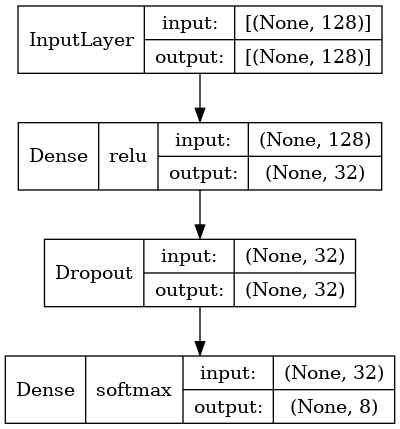

In [12]:
# 모형 구조 출력
print(model.summary())

# 연결 그래프 시각화
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, show_layer_activations=True)

<font color="blue"><p>
- 하이퍼모델 정의하기

In [13]:
def model_fn(hp):
    model.compile(loss='categorical_crossentropy', # Multiclass Classification에서 사용하는 loss function
                  optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), 
                  metrics=[keras.metrics.CategoricalCrossentropy()]) # Multiclass Classification에서 사용하는 평가지표
    return model

### Step 3: Build multiple hyper-tuned models

<font color="blue"><p>
- Tuner 설정 & 하이퍼튜닝 수행하기

In [14]:
tuner = kt.Hyperband(model_fn,
                     objective=kt.Objective('val_categorical_crossentropy', direction="min"), 
                     max_epochs=100,
                     hyperband_iterations=2,
                     seed=SEED,
                     overwrite=True,
                     directory='dnn_tuning')

tuner.results_summary(1)

Results summary
Results in dnn_tuning/untitled_project
Showing 1 best trials
Objective(name="val_categorical_crossentropy", direction="min")


In [15]:
%%time

# 하이퍼튜닝 수행: tuner.search()의 파라미터는 Keras의 model.fit() 파라미터와 동일
tuner.search(X_train, y_train, validation_data=(X_valid, y_valid), 
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

# 튜닝결과 요약
tuner.results_summary(num_trials=1)

Trial 3 Complete [00h 00m 05s]
val_categorical_crossentropy: 1.5790338516235352

Best val_categorical_crossentropy So Far: 1.5790338516235352
Total elapsed time: 00h 00m 19s
Results summary
Results in dnn_tuning/untitled_project
Showing 1 best trials
Objective(name="val_categorical_crossentropy", direction="min")

Trial 0002 summary
Hyperparameters:
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 1.5790338516235352
CPU times: user 17.4 s, sys: 1.89 s, total: 19.3 s
Wall time: 19.1 s


<font color="blue"><p>
- 최적의 하이퍼파라미터로 모델 재학습하기

In [16]:
# 모델 재현시 Seed 고정 필요
reset_seeds(SEED)

# 베스트 모델 사용
model = tuner.get_best_models(1)[0]
# submission 화일명에 사용
val_rmse = model.evaluate(X_valid, y_valid, verbose=0)[1]

# 전체 데이터로 재학습
hist = model.fit(
    x=np.concatenate((X_train, X_valid)),
    y=np.concatenate((y_train, y_valid)),
    batch_size=BATCH_SIZE*2, # 튜닝할 때 사용한 값과 다른 값으로 설정하는 것이 좋을 수 있음 
    epochs=16,                # 작은값으로 설정
    shuffle=False,      
    verbose=1,
)

Epoch 1/16
257/257 [==============================] - 2s 3ms/step - loss: 1.5633 - categorical_crossentropy: 1.5633
Epoch 2/16
257/257 [==============================] - 1s 3ms/step - loss: 1.5593 - categorical_crossentropy: 1.5593
Epoch 3/16
257/257 [==============================] - 1s 3ms/step - loss: 1.5595 - categorical_crossentropy: 1.5595
Epoch 4/16
257/257 [==============================] - 1s 3ms/step - loss: 1.5560 - categorical_crossentropy: 1.5560
Epoch 5/16
257/257 [==============================] - 1s 3ms/step - loss: 1.5560 - categorical_crossentropy: 1.5560
Epoch 6/16
257/257 [==============================] - 1s 3ms/step - loss: 1.5544 - categorical_crossentropy: 1.5544
Epoch 7/16
257/257 [==============================] - 1s 3ms/step - loss: 1.5533 - categorical_crossentropy: 1.5533
Epoch 8/16
257/257 [==============================] - 1s 3ms/step - loss: 1.5545 - categorical_crossentropy: 1.5545
Epoch 9/16
257/257 [==============================] - 1s 3ms/step - loss

### Step 4: Make submissions

In [17]:
# 예측값 얻기
pred = pd.DataFrame(model.predict(X_test))
pred.columns = ['F20','F30','F40','F50','M20','M30','M40','M50']

# submission 화일 생성
t = pd.Timestamp.now()
filename = f"dnn_submission_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
pd.concat([pd.Series(IDtest, name="ID"), pred] ,axis=1).to_csv(filename, index=False)

print(f"'{filename}' is ready to submit.")

450/450 [==============================] - 1s 2ms/step
'dnn_submission_06200754.csv' is ready to submit.


<font color="#CC3D3D"><p>
# End